In [40]:
from sklearn.datasets import fetch_olivetti_faces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [41]:
data = fetch_olivetti_faces()
X = data.data
y = data.target
img = data.images
print(f"The shape of dataset is : {X.shape}")
print(f"The shape of target is : {y.shape}")
print(f"The number of classes are: {len(np.unique(y))}")
print(f"The number of images are : {img.shape[0]}")
print(f"The shape of image is : {img.shape[1:]}")

The shape of dataset is : (400, 4096)
The shape of target is : (400,)
The number of classes are: 40
The number of images are : 400
The shape of image is : (64, 64)


In [42]:
img_train, img_test, img_val = [], [], []
y_train, y_test, y_val = [], [], []

for person in np.unique(y):
    idx = np.where(y == person)[0]

    img_train.append(img[idx[:7]])
    y_train.append(y[idx[:7]])

    img_val.append(img[idx[7:8]])
    y_val.append(y[idx[7:8]])

    img_test.append(img[idx[8:]])
    y_test.append(y[idx[8:]])


In [43]:
img_train_array = np.concatenate(img_train, axis=0)
img_test_array  = np.concatenate(img_test, axis=0)
img_val_array   = np.concatenate(img_val, axis=0)

y_train = np.concatenate(y_train, axis=0)
y_test  = np.concatenate(y_test, axis=0)
y_val   = np.concatenate(y_val, axis=0)

# Flatten each image
img_train_flat = img_train_array.reshape(img_train_array.shape[0], -1)
img_test_flat  = img_test_array.reshape(img_test_array.shape[0], -1)
img_val_flat   = img_val_array.reshape(img_val_array.shape[0], -1)

print(f"Training set: {img_train_flat.shape}")
print(f"Testing set:  {img_test_flat.shape}")
print(f"Validation set: {img_val_flat.shape}")


Training set: (280, 4096)
Testing set:  (80, 4096)
Validation set: (40, 4096)


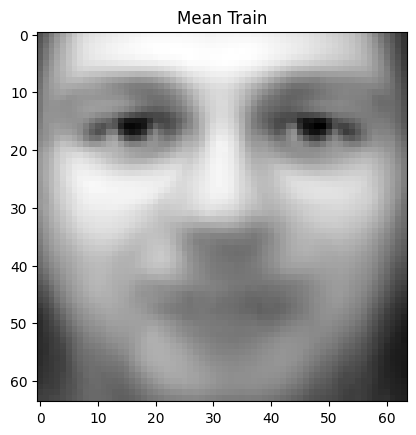

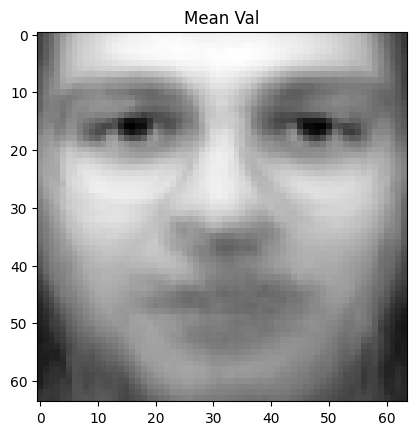

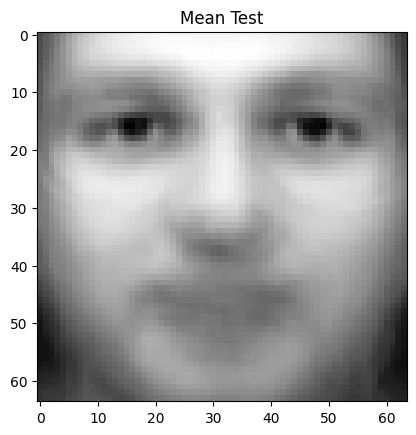

In [44]:
import matplotlib.pyplot as plt

mean_img_train = np.mean(img_train_flat, axis=0).reshape(64,64)
mean_img_val   = np.mean(img_val_flat, axis=0).reshape(64,64)
mean_img_test  = np.mean(img_test_flat, axis=0).reshape(64,64)

plt.imshow(mean_img_train, cmap='gray'); plt.title("Mean Train"); plt.show()
plt.imshow(mean_img_val, cmap='gray'); plt.title("Mean Val"); plt.show()
plt.imshow(mean_img_test, cmap='gray'); plt.title("Mean Test"); plt.show()


In [45]:
class PCA_scratch:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        self.mean= np.mean(X, axis=0)
        Xc = X - self.mean
        cov = np.cov(Xc, rowvar=False)
        eigvals, eigvecs = np.linalg.eigh(cov)
        idx = np.argsort(eigvals)[::-1]
        self.components= eigvecs[:, idx[:self.n_components]]

    def transform(self, X):
        Xc = X - self.mean
        return Xc @ self.components

In [ ]:
k_values = [5,10,15,20,25,30,40,50,75,100,150,200,279]
accuracies = []

for k in k_values :
  pca = PCA_scratch(n_components=k)
  pca.fit(img_train_flat)
  img_train_pca = pca.transform(img_train_flat)
  img_val_pca = pca.transform(img_val_flat)

  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(img_train_pca, y_train)
  y_pred = knn.predict(img_val_pca)
  accuracy = np.mean(y_pred == y_val)
  print(f"Accuracy for k={k}: {accuracy:.3f}")
  accuracies.append(accuracy)

Accuracy for k=5: 0.700
Accuracy for k=10: 0.875
Accuracy for k=15: 0.925


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k (Number of Eigenvectors)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Number of Eigenvectors')
plt.grid(True)
plt.show()

In [ ]:
best_idx = np.argmax(accuracies)
best_k = k_values[best_idx]

pca_best = PCA_scratch(n_components=best_k)
pca_best.fit(img_train_flat)
eigenfaces = pca_best.components.T.reshape(-1, 64, 64)

plt.figure(figsize=(12,6))
for i in range(best_k):
    plt.subplot(4, best_k//4 + 1, i+1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.axis('off')
plt.suptitle(f'Eigenfaces for k={best_k}')
plt.show()

In [ ]:
img_train_pca = pca_best.transform(img_train_flat)
img_test_pca  = pca_best.transform(img_test_flat)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(img_train_pca, y_train)
y_test_pred = knn.predict(img_test_pca)
test_accuracy_scratch = np.mean(y_test_pred == y_test)

In [ ]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=best_k)
img_train_sk = sklearn_pca.fit_transform(img_train_flat)
img_test_sk  = sklearn_pca.transform(img_test_flat)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(img_train_sk, y_train)
y_test_pred_sk = knn.predict(img_test_sk)
test_accuracy_sklearn = np.mean(y_test_pred_sk == y_test)

print("Best k:", best_k)
print("Test Accuracy (Scratch PCA):", test_accuracy_scratch)
print("Test Accuracy (Sklearn PCA):", test_accuracy_sklearn)
